# Expression Prediction Using Convolutional Neural Networks
Project mentor: Darius Irani

Daniel Shenker <dshenke1@jh.edu>, Mitchell Pavlak <mpavlak1@jh.edu>, Cherlin Zhu <czhu27@jh.edu>, Arjun Somayazulu <asomaya1@jh.edu>

Link_to_git_repo: https://github.com/dshenker/ML2020FinalProject

# Outline and Deliverables

List the deliverables from your project proposal. For each uncompleted deliverable, please include a sentence or two on why you weren't able to complete it (e.g. "decided to use an existing implementation instead" or "ran out of time"). For each completed deliverable, indicate which section of this notebook covers what you did.

If you spent substantial time on any aspects that weren't deliverables in your proposal, please list those under "Additional Work" and indicate where in the notebook you discuss them.

### Uncompleted Deliverables
1. "Expect to complete #2": Could not achieve higher accuracy on simple CNN than SVM. We instead switched to using the transfer learning approach and were successful when we took this route.
2. "Would like to complete #1": Test robustness through data augmentation. We found that data augmentation greatly affected the performance of dlib in identifying feature landmarks. [in "What you've learned"](#scrollTo=ugJXhZKNlUT4).


### Completed Deliverables
1. "Must complete #1": We built our benchmark SVM [in "Baselines"](#scrollTo=oMyqHUa0jUw7&line=5&uniqifier=1).
2. "Must complete #2": We built a simple CNN [in "Baselines"](#scrollTo=oMyqHUa0jUw7&line=5&uniqifier=1).
3. "Must complete #3": We built a multi-task CNN [in "Methods"](#scrollTo=PqB48IF9kMBf).
4. "Expect to complete #1": Ran models on Yale Database [in "Generalizing to the Yale faces dataset"](#scrollTo=qqc9FXA8zCtF).
5. "Expect to complete #3": Achieved better accuracy for expression classification on multi-task CNN than simple CNN [in "Results"](#scrollTo=_Zdp4_H-kx8H).
6. "Would like to complete #2": Implement transfer learning with resnet and compare to transfer learning [in "Methods"](#scrollTo=PqB48IF9kMBf).
7. "Would like to complete #3": Quantify improvement from adding facial landmarks to CNN [in "Results"](#scrollTo=_Zdp4_H-kx8H).




# Preliminaries

## What problem were you trying to solve or understand?

At first we wanted to train a model to distinguish between different emotions based on images of people's faces. However, we realized that emotions are incredibly nuanced, such that even people are unable to accurately identify them. We decided to focus instead on categorizing by more general expressions such as happiness, sadness, and anger. One main application of a successful model is to improve interactions between humans and machines, with machines being able to adjust based on the expressions of people. It could also help with measuring responses to marketing and/or entertainment content.

## What are the real-world implications of this data and task?
Expressions are an important component of social interactions. They are useful to convey our reactions and can be factored into how we interact. It is important to note that our data has been labelled by people, and the labels are subjective because expressions and emotions are so personal and individual. Moreover, these images include those of actors or people who may not be "actually sad" but are rather putting on a certain emotion on purpose. However, interpretation of these people's emotions by observers is still the task being solved here.

## How is this problem similar to others we’ve seen in lectures, breakouts, and homeworks?
This problem can be turned into a multiclass classification because we are using labeled data. Because we are using images, this problem is very similar to the lectures on Neural Networks, especially CNNs. We are also applying what we learned about SVMs because we are able to extract features using dlib facial landmark mapping.

##Why is this problem important?
Working on this problem has the potential to aid individuals who have trouble with social interactions, as well as improve interactions between humans and computers. In general, it is key to understanding an individual's facial expression, which is applicable to most industries, including in safety (i.e. identifying when a driver is beginning to feel drowsy) and marketing (i.e. gauging reactions to marketing material).

##What ethical implications does this problem have?
There is always a risk associated with classifying images of people. First of all, models often have implicit biases depending on how labels were generated. There have been examples of similar algorithms outputing data that was biased by gender and race, for example tending to misclassify other expressions as anger for images of black people. This becomes extremely problematic when such models are applied to decisions that have significant effects on people. Consider applications in social justice or security: racial biases would result in disproportionate punishment/detainment of certain demographics.

## Dataset(s)

### Overview of the Datasets

We used two datasets. The Facial_expressions dataset we found on Github contains almost 14000 labelled images. The labels are anger, surprise, disgust, fear, neutral, happiness, sadness, and contempt. These images are black and white photos cropped around faces, all of which have been contributed by graduate students. This dataset was chosen due to its size, variety of labels, and variety of image angles (which makes the data more generalizable).

The second dataset, the Yale Face Database, only contain 165 images, 11 people with 15 images each. These images were taken specifically to fit the 15 labels, which are not confined to expressions but include wearing glasses, winking, etc. This dataset was chosen to test our models on to see how generalizable they are since the "types" of images seen there are very different. For example, subjects in this study were specifically told to put on a certain emotion and are thus very exagerated.


### Github Dataset

Let's first take a look at the faces dataset on Github

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
git_images = np.load("drive/MyDrive/ML_Final/image_dataset_upsample_final.npz") #load the images file


(1500, 350, 350)

We can print out a few examples of the data 

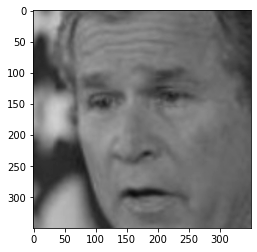

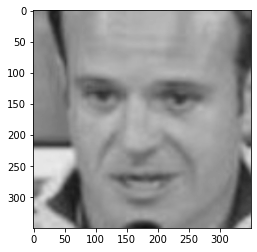

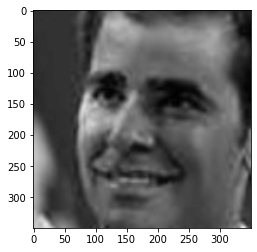

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
images = git_images["x"]

for i in range(3):
  img = images[i]
  plt.figure()
  plt.imshow(img,cmap='gray', vmin=0, vmax=255)

We can see that these images are 350 by 350 and are focused on the face of the individual. Each image is then labeled with the expression being exhibited. The labels are subjective decisions that were made by the creators of the dataset, which we are assuming to be true in this project (an important assumption to consider when we evaluate performance). In addition, we have 1500 examples being used for modeling.

### Yale Faces Dataset

Next let's look at examples from the Yale faces dataset

---



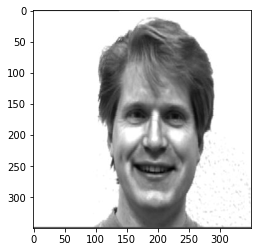

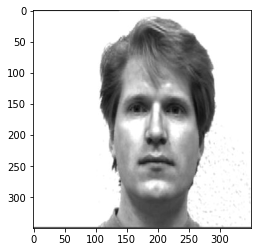

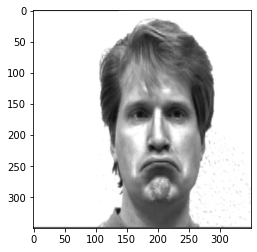

In [ ]:
git_images = np.load("drive/MyDrive/ML_Final/image_dataset_yale.npz") #load the images file
images_yale = git_images["x"]

for i in range(3):
  img = images_yale[i]
  plt.figure()
  plt.imshow(img,cmap='gray', vmin=0, vmax=255)

We notice a couple of things here. First, the emotions in these images are more exaggerated. This is because instead of the images coming from "real life" scenarios as they do in the github dataset, these are pictures that were taken after an individual was SPECIFICALLY TOLD to put on a certain emotion. Also note that the images here have been rescaled to 350 by 350 so that they match the dimensions of those that we trained our models on.

## Pre-processing

Link to the overall script for pre-processing is: https://github.com/dshenker/ML2020FinalProject/blob/main/Machine_Learning_Final_DataProcessing.ipynb

### What features did you use or choose not to use? Why?
For our CNN and MTCNN, we pass the entire 350 by 350 images to the model. For our SVM however, as detailed below, we use the dlib library to identify facial landmarks and utilize these coordinates as features.

### If you have categorical labels, were your datasets class-balanced?
No, see the class balance section below for details.

### How did you deal with missing data? What about outliers?
Luckily we did not have missing data. However, we had outliers in the sense that some of the labels in our dataset had too few examples to justify their use. For example, one such label only had 12 examples, which is not a sufficient amount to upsample. Thus, examples with these labels were removed (as described below).

### Summary of pre-processing

The first issue we noticed with our Github data was that the images were different sizes. However the majority of them were 350x350 so those were the ones we kept. Within those of size 350x350, the labels were not balanced. The sets for fear, contempt, and disgust were much smaller than the others, so we dropped those. We then upsampled as necessary to get balanced classes. We used two features: the facial landmarks from dlib and the images themselves. We flattened the facial landmarks into an array containing the coordinates of features from dlib. The images were normalized before training our CNNs.

### Getting data ready for the SVM

A Support Vector Machine (SVM) cannot take as input an image itself. Rather, we needed a way to quantify what was going on in the image. To do this, we use python's dlib package to find x and y coordinates of facial landmarks. The intuition behind this is that facial landmarks (such as the location of the nose, mouth, etc.) capture information about someone's expression. For example, having a mouth that is very wide open could indicate excitement. Below, see an example of how we find the facial landmarks

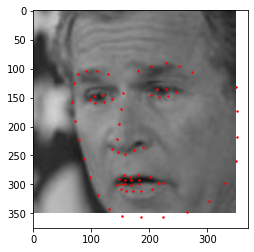

In [ ]:
import dlib
landmark_detector = dlib.shape_predictor('drive/MyDrive/ML_Final/shape_predictor_68_face_landmarks.dat')

img = images[0]
rect = dlib.rectangle(0,0,img.shape[1],img.shape[0])
landmarks = landmark_detector(img,rect)
plt.figure()
plt.imshow(img,cmap='gray', vmin=0, vmax=255)
for p in landmarks.parts():
  plt.scatter(p.x,p.y,s=2,c='r')

The red dots here indicate where dlib has placed the facial landmarks. This performance is something we were very happy with and indicated to us that we could be confident that the quality of data we would be passing into our SVM would be high. Thus, we proceeded to perform this operation on every image and create a dataset of the landmarks for each image (i.e. a dataset of x and y coordinates for the landmarks).

### Distribution of class labels

The original dataset had quite an imbalance in terms of the distribution of labels, as seen below

<BarContainer object of 15 artists>

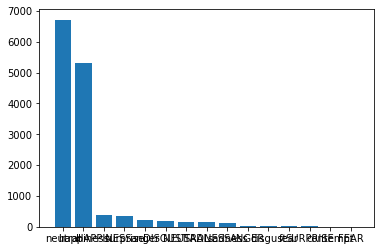

In [ ]:
import pandas as pd
labels_beforepreprocess = pd.read_csv('drive/MyDrive/ML_Final/facial_expressions-master/data/legend.csv')['emotion'].value_counts()
plt.bar(labels_beforepreprocess.keys(), labels_beforepreprocess)

Clearly this is not an even distribution. To balance this out, as well as to make training our models more feasible, we made the decision to restrict our model to the expressions neutral, happiness, surprise, anger, and sadness. The rest of the expressions had too few examples to have hope in the model performing well. In addition, we limited our data to 300 examples of each, which was achieved by upsampling the sadness and anger classes since these did not have 300 examples (but had close enough to this amount to justify including them). We upsampled using rotations and through the addition of Gaussian noise.

<BarContainer object of 5 artists>

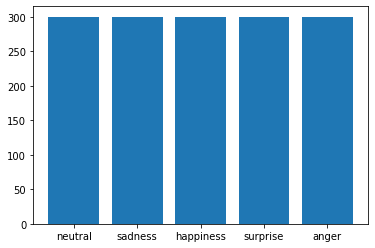

In [ ]:
from collections import Counter
y_train = np.load('drive/MyDrive/ML_Final/Upsampled_Data/y_train_upsample_final.npy')
y_validate = np.load('drive/MyDrive/ML_Final/Upsampled_Data/y_validate_upsample_final.npy')
y_test = np.load('drive/MyDrive/ML_Final/Upsampled_Data/y_test_upsample_final.npy')
labels_post = np.concatenate((y_train, y_validate, y_test))
labels_count = Counter(labels_post)
plt.bar(labels_count.keys(), labels_count.values())

This fixes our class imbalance when training our models.

### Yale Data

We did not perform any preprocessing on the Yale data apart from the dlib feature extraction seen earlier. This was because of our intention to test our models generalizability. However, we did have to "map" the labels in the Yale dataset to those that we have in our training set. In particular, the Yale label of "normal" became "neutral", "surprised" became "surprise", "happy" changed to "happiness", and "sad" to "sadness". It is also important to note that there are no examples of the "anger" label here. Below, see a distribution of the final labels used in the Yale dataset.

In [ ]:
yale_labels = np.load("drive/MyDrive/ML_Final/Yale_labels.npy")
yale_labels_count = Counter(yale_labels)
yale_labels_count

Counter({'happiness': 15, 'neutral': 15, 'sadness': 15, 'surprise': 15})

<BarContainer object of 4 artists>

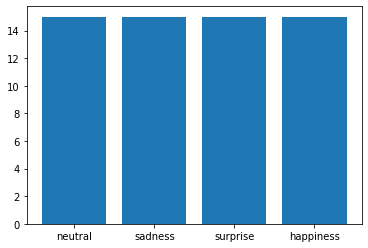

In [ ]:
plt.bar(yale_labels_count.keys(), yale_labels_count.values())

We see that we have perfect class balance here

# Models and Evaluation

## Experimental Setup

### How did you evaluate your methods? Why is that a reasonable evaluation metric for the task?

To evaluate performance we used accuracy to measure overall performance and confusion matrices to understand specific class performances and the mistakes our models were making. For more specific tasks there are likely better evaluation metrics than accuracy, but since our goal was to compare the overall performance of our models we believe accuracy is the best choice here.

### What did you use for your loss function to train your models? Did you try multiple loss functions? Why or why not?

For our SVM, we used the hinge loss function as this is the standard loss function for that method. For our CNN models, we used cross entropy loss, as we had multiclass categorical labels. For our MTCNN model, we were learning both the emotion label as well as the landmark locations, so we used cross entropy for the former, and Mean-Squared Error Loss for each continuous-valued x and y landmark location. The two loss functions for MTCNN were combined into a single value using a tuned weighting scheme.

### How did you split your data into train and test sets? Why?

When splitting our data we had to make sure that all images of the same individual were in the same split. Thus, we created train, dev, and test splits of the names and then put the associated images in there. Specifically, we used a 80, 10, 10 split of the data.


Link to file related to train/test splits and data prep: https://github.com/dshenker/ML2020FinalProject/blob/main/Machine_Learning_Final_DataProcessing.ipynb

## Baselines 

We have two baselines: the accuracy from our SVM and our CNN with transfer learning. Our main model is a multi task CNN using both facial landmarks and the images themselves as input, which we expect to perform better than the two images separately. Our SVM taking in only the coordinates of the facial landmarks achieved an unexpectedly high test accuracy of .62. On the other hand, our basic CNN achieved both dev and test accuracies of .8466.

Both of these are reasonable baselines. First, the SVM tests how well our model can perform using JUST quantifiable information about the image, not the pixels themselves. When we achieve improvement over this baseline it signifies that the image itself is adding something to our understanding of the problem.

Our simple CNN is a good baseline because it gives us a great jumping off point for our more complicated MTCNN. Here, we are just using the images while in the MTCNN we seek to preserve landmarks as well. Thus, this allows us to compare the two models performances' to see if using a multitask approach is helpful or not.

## Methods



### SVM (https://github.com/dshenker/ML2020FinalProject/blob/main/ML_Final_SVM_Details.ipynb)
We chose an SVM due to it being a simple model to train and because it takes in numerical inputs. This allowed us to test our hypothesis that facial landmarks are important in understanding expression. We tuned a variety of parameters here, including the value of C, the choice of decision function, and kernel type. The model was most sensitive to C and the kernel type. Specifically, very small values of C drastically decreased performance, and switching to a polynomial kernel of degree 3 helped us a great deal. Due to the relative simplicity and quick training time, the SVM was definitely the easiest model for us to implment. Below, find a link to the notebook detailing the SVM.


### Resnet CNN (https://github.com/dshenker/ML2020FinalProject/blob/main/Final_Expression_CNN_with_Transfer_Learning.ipynb)

We used a CNN because our data are images, and so with domain-knowledge that CNNs work well to capture spatial dependencies we wanted to evaluate performance of a CNN on this data. We first created a custom 2-layer CNN, but the small dataset size given this model quickly overfit the dataset. Hyperparameter tuning of the convolutional layers, the kernel size, the number of training epochs, the learning rate and various dropout as well as pooling configurations did not fix this overfitting issue, so we tried a transfer learning approach. To do this, we used ResNet18 in a transfer learning style setting as our model, removing the final layer to replace with a softmax layer for the classes we want to predict. With ResNet18 we were largely constrained to optimizing non-model hyperparameters, such as number of training epochs and learning rate. We achieved optimal test set accuracy when the learning rate was 0.001 and the model was trained for 25 epochs.


### MTCNN (https://github.com/dshenker/ML2020FinalProject/blob/main/Final_Expression_Multitask_CNN.ipynb)
Our multi-task CNN was based on the idea that we know that the locations of facial landmarks conveys information about expression. Rather than using a more traditional means of regularization, we wanted to penalize any models that were unable to recover facial landmarks.

We wanted to stay relatively close to our ResNet based model for comparison purposes, so we used the base pretrained ResNet18 model and attached two fully connected layers with one predicting the 5 categories and the other predicting the 136 x and y coordinates making up the 68 facial landmark points. 

Prior to starting training, we already guessed that the effect of the global average pooling layer at the end of ResNet18 would remove the vast majority of spatial information left from the convolutional layers, and testing experimentally revealed that this was the case (we found that our network could not accurately determine facial landmark location, and instead appeared to learn a mean location with only slight shifts image to image). 

To solve this, we directly attached the secondary fully connected layer to the output of the final convolutional layer, and noticed substantially improved results and fairly accurate landmark reconstructions. Below see a depiction of the model structure:

![picture](https://drive.google.com/uc?export=view&id=1h5rXjwk3A7LmES9jY-qrqzX6r2mxueLp)

To train the model, we use a combination of MSE loss for the facial landmarks and Cross Entropy for the expression. Because the size of the MSE loss was substantially larger than the Cross Entropy loss, we needed to weight the two to successfully train the network on both tasks. To do this, we made the loss a weighted sum of Cross Entropy * Weight + MSE / the same weight. We made a few preruns that used either the Cross Entropy alone or MSE alone, and determined our classification task appeared to converge around the order of a loss of .024, while our landmark prediction task appeared to converge around .9. We initialized with the ratio of the two--37.5--and experimented with both making the weight a learnable parameter (ie making the parameter .375 and learnable and using the weight of parameter * 100) and a fixed parameter.

We found we acheived the best results when leaving the parameter fixed at 37.5, but intentionally left the parameter learnable knowing that the extremely small updates (ie 37.5 to 37.081) would not affect the loss but would indicate whether or not we should adjust our weight. Because we can see when training our models that the weight sometimes increases and sometimes decreases, it lets us know that our loss functions are relatively balanced.




### Visualizing Training

Below we can see the training curve for the SVM. On the y axis we have the accuracy score and on the x axis the number of examples. We can see that as we add more examples, the training score decreases but the cross validation score increases. Additionally, we see that the score appear to be converging towards the latter portion of the graph, which is encouraging to see. This demonstrates to us that training is working as expected here.

![picture](https://drive.google.com/uc?export=view&id=18qGFC_GZbrs3STsdaaDZ8e381f0pmcA3)

Below we can see the CNN Training Loss, Dev Loss, and Dev accuracy for our Resnet CNN model. We can see that after running for about 25 epochs there is convergence in all three metrics. This suggests that we do not need to train longer but have rather found the optimum. Our Dev accuracy stabilizes at around .85.

![picture](https://drive.google.com/uc?export=view&id=1FxFeupPbs0jprHpjIgMvD4UIpkC7GUgS)


![picture](https://drive.google.com/uc?export=view&id=1hF1v7_oMEjJOAYrik_SYjzg9eIt0OKIb)


![picture](https://drive.google.com/uc?export=view&id=1ts8g3fvoqJ73dy_y7bj7LlakAbiL1fiE)

Below we see analogous plots but this time for our MTCNN. Once again, after 25 epochs our training and dev loss are converging, as is our dev accuracy (although possibly not as convincingly as before). We chose 25 epochs here to most accurately compare our performance to the resnet model, however we found experimentally that this may not be full convergence.

![picture](https://drive.google.com/uc?export=view&id=1-5CrzlyuvyDtA9r_ACE70KjxfUFhyKKd)


![picture](https://drive.google.com/uc?export=view&id=1-7dcVM-URA7Ssu3NFG6j5e0VGaJ5V4dl)


![picture](https://drive.google.com/uc?export=view&id=1-4avADCtD4h6beChSY6N9uhcNDKlpVSx)



## Results

 

CONFUSION MATRIX FOR SVM

![picture](https://drive.google.com/uc?export=view&id=1Xhv_5xnzLm4TJgt_dFhWF_Nt9o09bqHp)


We can see that performance is best for the anger and happiness emotions. We do get better than chance accuracy on every emotion, however sadness struggles the most (note that this is one of the classes that we upsampled). In particular, sadness is often being categorized as neutral instead. Given that we are only using facial landmarks, this performance on the test dataset is better than we had expected.

CONFUSION MATRIX FOR RESNET CNN

![picture](https://drive.google.com/uc?export=view&id=1BBIM_3Tum858dyZd98_utVdA5UZXNu_R)



We see that, compared to the SVM, we get improvements in accuracy across all of the expressions. The most notable improvement is in sadness, where we have a jump from 0.37 to 0.93. As a result, we also have less pronounced issues of misclassification, with the only glaring issue being the error of classifying happiness as neutral, which is one that we would expect to occur due to their similarities.

CONFUSION MATRIX FOR MTCNN

![picture](https://drive.google.com/uc?export=view&id=1wYbnDKfjj-DWRCagYglTKPIpVHZYhPOG)


Here, apart from sadness, we have improvement in all expressions over our Resnet CNN. Although there is decrease, the overall accuracy of the model increased, making it more well rounded. We see, however, that more sadness images were being classified as anger, which could be linked to the facial landmarks that may be similar between a person who is sad or angry. 

VISUALIZING PERFORMANCE OF FACIAL LANDMARK PREDICTION IN THE MTCNN

![picture](https://drive.google.com/uc?export=view&id=1-HYTiwZ_2hxXUtjyk_DlZv5inibDY33c)



Here, the red dots denote the landmarks found by dlib and those in blue are the landmarks predicted by the MTCNN. Given that the MTCNN was free to place the blue dots in any (x,y) coordinates it wanted to, we were very impressed by its performance as it places the landmarks very close, in terms of distance, to those found by dlib. Additionally, even though this goes through a max pooling layer and the output of the convolution layers is very small relative to the starting image dimensions, we still find the landmarks with high accuracy. This demonstrates to us that the MTCNN is successfully preserving facial landmark locations.

OVERALL TABLE OF COMPARISON OF ACCURACIES




![picture](https://drive.google.com/uc?export=view&id=110mqSnn3qx5Hw-GHcM4bMxD4sC3DZjw2)



This table allows us to see the overall accuracies for each emotion across the models. Once again, apart from sadness, we see the clear ordering of MTCNN performing best, followed by the Resnet CNN, and then the SVM in third. This matches our hypothesis that the MTCNN would perform best due to its combination of using the entire image as features along with the preservation of information on the facial landmarks as a form of regularization. Additionally, as we discussed earlier, the MTCNN may not have converged, thus training for more epochs may demonstrate even better results.

# Generalizing to the Yale faces dataset

To test the generalizibility of our models, we ran all of them on the Yale datset described earlier. Overall, we experienced some issues here due to dlib not functioning as we expected. However, we were able to get a decent accuracy of 0.45 using the Resnet CNN. Overall, this suggests that, given some more time, there may be ways to improve the models so that they function on new image datasets. For details of this process, please see: https://github.com/dshenker/ML2020FinalProject/blob/main/ApplyingToYaleData.ipynb

# Discussion

## What you've learned



### What concepts from lecture/breakout were most relevant to your project? How so?

The concepts of data processing, feature creation, SVM's, and CNN's were most relevant to our project. Data processing was important when we fixed our class imbalances and ensured that all of our data was in the same format. Then, using python's dlib package, we were able to identify facial landmarks to use as features in our SVM. Finally, SVM's and CNN's were our models of choice, where we used much of the information from class to tune these models.

### What aspects of your project did you find most surprising?

We found the performance of the SVM most surprising. With just the location of facial landmarks, the model was able to achieve surprisingly high performance on all the expressions. This confirmed our hypothesis that facial landmarks can tell you a great deal about someone's expression, justifying our decision to work towards implementing a MTCNN.

### What lessons did you take from this project that you want to remember for the next ML project you work on? Do you think those lessons would transfer to other datasets and/or models? Why or why not?

We learned about the importance of trying good baseline models (simpler models) before moving on to more complex ones. For example, we observed surprisingly good accuracy with our SVM, and it is entirely possible that for the next task that we work that a baseline SVM could perform the task with sufficient accuracy, saving valuable time and resources. We also saw this in the CNN portion of our project; our initial custom built model achieved poor accuracy but using transfer learning with resnet18 we were able to achieve a much higher accuracy.

### What was the most helpful feedback you received during your presentation? Why?

Some helpful feedback that we had not considered is that if we are to implement any data augementation to improve our model's generalizibilty, we need to consider how this will affect landmark prediction by our MTCNN. This means we need to carefully consider what data augmentation techniques would be appropriate in this case, or whether we should simply improve our generaliziblity by training on (un-augmented) data from a wider range of datasets in order to preserve the integrity of the landmarks.

### If you had two more weeks to work on this project, what would you do next? Why?

We would want to better evaluate the performance of this model on other datasets. This is important because we can measure the generalizibilty of our model, which is ultimately what we are trying to optimize in order to actually deploy an ML model in the real world. Although we were able to get started on this task, we would like to have more time to more deeply investigate the models' generalizability